In [63]:
%matplotlib inline
import autograd.numpy as np
import pylab as plt
import matplotlib.colors as colors
import seaborn as snb

from exercise6 import compute_err
from exercise6 import eval_density_grid
from exercise6 import load_MNIST_subset
from exercise6 import plot_with_uncertainty
from exercise6 import add_colorbar
from exercise6 import StationaryIsotropicKernel
from exercise6 import squared_exponential
from exercise6 import matern12
from exercise6 import matern32
from exercise6 import NeuralNetworkMAP
from exercise6 import generate_samples

# from autograd import grad, 
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.stats import binom as binom_dist

snb.set_style('darkgrid')
snb.set_theme(font_scale=1.1)


# 02477 Bayesian Machine Learning: Gaussian processes classification

The purpose of this exercise is to
- get familiar with Bayesian modelling with non-Gaussian likelihoods, we will study the Bernoulli likelihood in particular.
- study Gaussian processes for binary classification via the Laplace approximation
- dive deeper into Gaussian processes


**Content**

- Part 1: Theory for binary classification using Gaussian process
- Part 2: Implementing the Laplace approximation (Step 1 of 3)
- Part 3: Implementing the posterior distribution of $p(f^*|\mathbf{y}, \mathbf{x}^*)$ (step 2 of 3)
- Part 4: Compute the posterior predictive distribution of the label $y^*$ for the input point $\mathbf{x}^*$, i.e. to compute $p(y^*|\mathbf{y}, \mathbf{x}^*)$. (Step 3 of 3)
- Part 5: Gaussian process classification for 2D data set


**Note**: In this exercise, we will use the code from last week for the squared exponential kernel etc. We will also make use of a set of auxiliary functions, which are less important for the learning objectives of today and therefore, they can found in the module `exercise6.py`.

**Note**: The exercise contains several **discussion questions**, which are questions, where are supposed to actively experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs. Instead of proving the full description for every discussion question, we simply tag it with: [**Discussion question**] after the question.

# A toy dataset

First, we will implement and test everything on a simple 1D toy dataset. The dataset is generated using the following model:

$$\begin{align*}
y_n|x_n &\sim \text{Ber}(\sigma(f(x_n)))\\
f(x_n) &= 5 \sin\left(\frac{3}{4}x\right)\\
x_n &\sim \mathcal{N}(0, 2.5^2),
\end{align*}$$

Hence, the true data generating process is $p(y=1|x) = \sigma(5\sin(\frac{3}{4} x))$, where $\sigma(x) = \frac{1}{1 + e^{-x}}$ is the logistic sigmoid function.

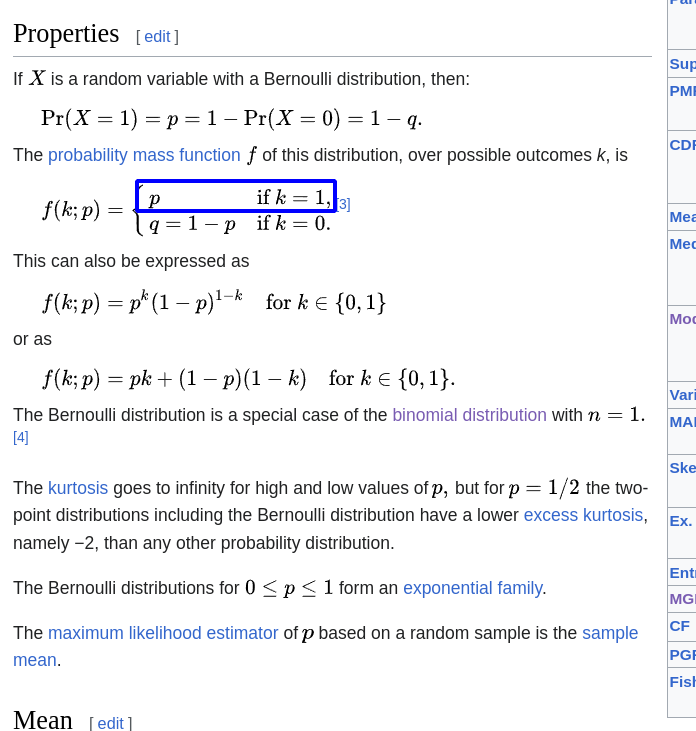

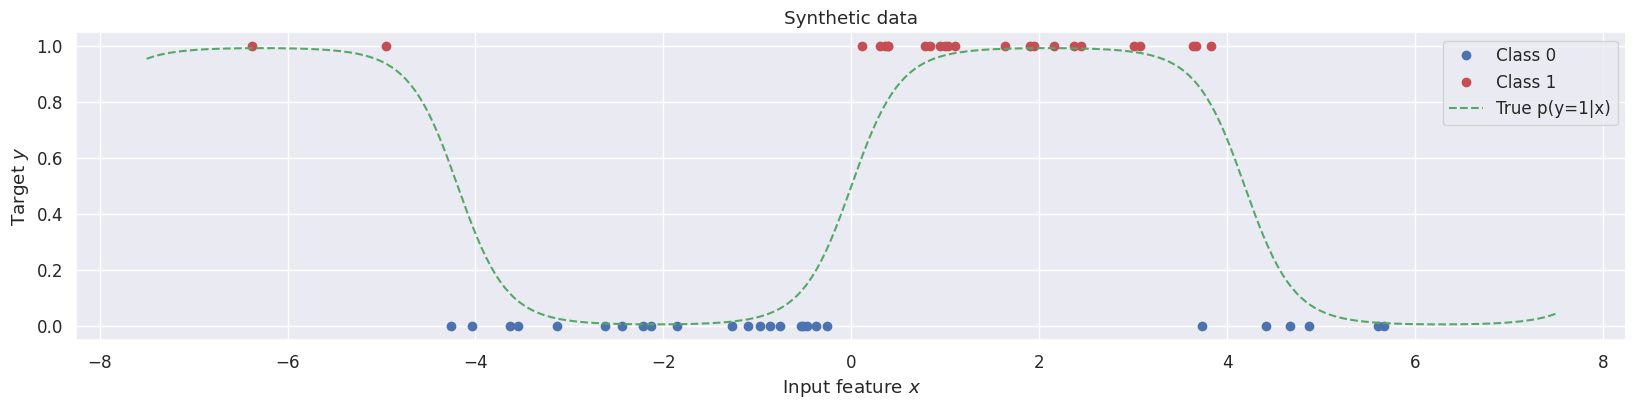

In [64]:
np.random.seed(0)

sigmoid = lambda x: 1./(1+np.exp(-x))

# true p(y=1|x) = sigmoid(f(x))
f = lambda x:  5*np.sin(0.75*x)

N = 50
X = np.sort(np.random.normal(0, 2.5, size=N))[:, None]
y = np.random.binomial(1, sigmoid(f(X)))

# define points for prediction/plotting
Xstar = np.linspace(-7.5, 7.5, 300)[:, None]

# plot data
def plot_data(ax, X, y, title="Synthetic data", plot_true=False):
    ax.plot(X[y==0], y[y==0], 'bo', label='Class 0')
    ax.plot(X[y==1], y[y==1], 'ro', label='Class 1')
    if plot_true:
        ax.plot(Xstar, sigmoid(f(Xstar)), 'g--', label='True p(y=1|x)')
    ax.set(xlabel='Input feature $x$', ylabel='Target $y$', title=title)
    ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(20, 4))
plot_data(ax, X, y, plot_true=True)


# Part 1:  Theory for binary classification using Gaussian process

We will study Gaussian processes for binary classification using the following model

$$\begin{align*}
y|f(\mathbf{x}) &\sim \text{Ber}[\sigma(f(\mathbf{x}))]\\
f(\mathbf{x}) &\sim \mathcal{GP}(0, k(\mathbf{x}, \mathbf{x}')),
\end{align*}$$

where $k(\mathbf{x}, \mathbf{x}')$ is the covariance function and $\sigma: \mathbb{R} \rightarrow (0, 1)$ is a suitable inverse link function. Here we will use the logistic sigmoid function. The purpose of the function $\sigma$ is to "squeeze" the values of $y(\mathbf{x})$ from the entire real line to the unit interval such that we can interpret $\sigma(f(\mathbf{x})) \in \left[0, 1\right]$ as a probability for all $\mathbf{x}$.

Our goal is to compute the predictive distribution $p(y^* = 1|\mathbf{y}, \mathbf{x}^*)$ for the class label $y^*$ of a new input point $\mathbf{x}^*$ given a dataset $\mathcal{D} = \left\lbrace \mathbf{x}_n, y_n \right\rbrace_{n=1}^N$ for $\mathbf{x} \in \mathbb{R}^D$ and $y_n \in \left\lbrace 0, 1 \right\rbrace$. Let $\mathbf{y} \in \left\lbrace 0, 1 \right\rbrace^N$ be the vector of binary observations and let $\mathbf{f} = \begin{bmatrix}f(\mathbf{x}_1) & f(\mathbf{x}_2) & \dots & f(\mathbf{x}_N) \end{bmatrix} \in \mathbb{R}^N$ be the corresponding vector of latent function values for each sample in the training set, then the joint model of the observations $\mathbf{y}$ and the latent function values $\mathbf{f}$ becomes

$$\begin{align*}
p(\mathbf{y}, \mathbf{f}) = p(\mathbf{y}|\mathbf{f})p(\mathbf{f}) = \prod_{n=1}^N \text{Ber}(y_n|\sigma(f_n)) \, \mathcal{N}(\mathbf{f}|\mathbf{0}, \mathbf{K}),
\end{align*}
$$

where we have assumed the observation to be conditionally independent given $\mathbf{f}$, and $\mathbf{K} \in \mathbf{R}^{N \times N}$ is the prior covariance matrix of $\mathbf{f}$, i.e. $\mathbf{K}_{nm} = k(\mathbf{x}_n, \mathbf{x}_m)$.

#### A 3-step approach for computing the posterior predictive distribution for $y^*$

Just like for the Bayesian logistic regression model, exact analytical Bayesian inference is intractable for this model, and therefore, we will resort to the Laplace approximation. Making predictions for a Gaussian process classification model using the Laplace approximation typically require threes steps:

- Step 1: Aproximating the posterior distribution $p(\mathbf{f}|\mathbf{y})$

- Step 2: Computing the posterior distribution of the latent function evaluated at a new point $\mathbf{x}^*$, i.e computing $p(f^*|\mathbf{y}, \mathbf{x}^*)$ where $f^* = f(\mathbf{x}^*)$.

- Step 3: Computing the posterior predictive distribution of the label $y^*$ for the input point $\mathbf{x}^*$, i.e. computing $p(y^*|\mathbf{y}, \mathbf{x}^*)$.

**Note**: For the regression models with Gaussian likelihoods, there is often a lot of confusion about the difference between $f^*$ and $y^*$. Part of this confusion is often caused by the fact that for regression $f^*$ and $y^*$ typically belong to the same mathematical space, e.g. $f^*, y^* \in \mathbf{R}$ and often $f^*$ can be interpreted as a *denoised* version of $y^*$. However, for binary classification models, the two quantities belong to different spaces, i.e. $f^* \in \mathbb{R}$ and $y^* \in \left\lbrace 0, 1 \right\rbrace$ and here it might be more clear that $f(\mathbf{x})$ simply is a latent function, which we introduce in order to model the distribution $\text{Ber}(y^*|\sigma(f^*))$.


# Part 2:  Implementing the Laplace approximation (Step 1 of 3)

Our goal is now to implement the Laplace approximation for $p(\mathbf{f}|\mathbf{y})$ such that

$$\begin{align*}
p(\mathbf{f}|\mathbf{y}) = \frac{p(\mathbf{y}|\mathbf{f})p(\mathbf{f})}{p(\mathbf{y})}\approx q(\mathbf{f}) = \mathcal{N}(\mathbf{y}|\mathbf{m}, \mathbf{S}),
\end{align*}$$

where $\mathbf{m} = \mathbf{f}_{\text{MAP}}$ is the MAP estimator for $\mathbf{f}$ and $\mathbf{S}$ is the negative inverse Hessian. As usual, we set-up the log joint distribution

$$\begin{align*}
\log p(\mathbf{y}, \mathbf{f}) &= \log p(\mathbf{y}|\mathbf{f}) + \log p(\mathbf{f})
%
= \sum_{n=1}^N \log  p(y_n|f_n) - \frac{N}{2}\log (2\pi) - \frac12 | \mathbf{K}| - \frac12 \mathbf{f}^T\mathbf{K}^{-1} \mathbf{f} 
\end{align*}$$

where the gradient and the Hessian are given by

$$\begin{align*}
\nabla_{\mathbf{f}} \log p(\mathbf{y}, \mathbf{f}) &= \sum_{n=1}^N \nabla_{\mathbf{f}}\log  p(y_n|f_n) - \frac12 \nabla_{\mathbf{f}}\mathbf{f}^T\mathbf{K}^{-1} \mathbf{f} = \mathbf{g} - \mathbf{K}^{-1} \mathbf{f},\\
%
\nabla_{\mathbf{f}}^2 \log p(\mathbf{y}, \mathbf{f}) &= \sum_{n=1}^N  \nabla_{\mathbf{f}}^2 \log  p(y_n|f_n) - \frac12 \nabla_{\mathbf{f}}^2\mathbf{f}^T\mathbf{K}^{-1} \mathbf{f}
=\sum_{n=1}^N  \nabla_{\mathbf{f}}^2 \log  p(y_n|f_n) - \mathbf{K}^{-1} 
=-\Lambda - \mathbf{K}^{-1},
\end{align*}$$

where $\mathbf{g} \in \mathbb{R}^N$ with entries given by $g_n = \frac{\partial}{\partial f_n}\log  p(y_n|f_n)$ and $\Lambda \in \mathbb{R}^{N \times N}$ is a diagonal matrix with elements $\Lambda_{nn} = -\nabla_{\mathbf{f}}^2 \log  p(y_n|f_n)$ evaluated at the mode $\hat{\mathbf{f}}_{\text{MAP}} = \argmax_{\mathbf{f}} \log p(\mathbf{y}, \mathbf{f})$. Thus, the mean and covariance matrix for the Laplace approximation $q(\mathbf{f}) = \mathcal{N}(\mathbf{f}|\mathbf{m}, \mathbf{S})$ become 

$$\begin{align*}
\mathbf{m} &= \hat{\mathbf{f}}_{\text{MAP}}\\
\mathbf{S} &= \left(\mathbf{K}^{-1} + \Lambda\right)^{-1}
\end{align*}$$

The expression for the posterior covariance matrix $\mathbf{S}$ involves the inverse of $\mathbf{K}$, which we know can be numerically unstable. To avoid having to compute the inverse of $\mathbf{K}$ explicitly, we will use the [**Woodbury matrix identity**](https://en.wikipedia.org/wiki/Woodbury_matrix_identity) to re-write the expression for the posterior covariance as 
$$\begin{align*}
\mathbf{S} &= \left(\mathbf{K}^{-1} + \Lambda\right)^{-1} = \mathbf{K} - \mathbf{K}\Lambda^{\frac12} (\underbrace{\mathbf{I} + \Lambda^{\frac12}\mathbf{K}\Lambda^{\frac12}}_{\mathbf{B}})^{-1} \Lambda^{\frac12} \mathbf{K}
\end{align*}$$

This might seem like a complicated way of calculating something simple, but the key thing is that the matrix $\mathbf{B} = \Lambda^{\frac12}\mathbf{K}\Lambda^{\frac12}$ is usually well-behaved because its eigenvalues are lowerbounded by $1$, and hence, the linear system $\mathbf{B}^{-1}\Lambda^{\frac12} \mathbf{K}$ can usually be solved without problems, e.g. via Cholesky decompositions.



#### The contributions of the likelihood to the gradient and Hessian

By inspecting the equations above, we see that both the gradient and Hessian contains a contribution from the prior and a contribution from the likelihood. First, will focus on implementing the contributions from the likelihood. We need to compute the first and second order derivatives of the log likelihood $\log p(y_n|f_n) = \log \text{Ber}(y_n|\sigma(f_n))$

**Task 2.1**: Show that first and second order derivative of $\log p(y_n|f_n)$ is given by $\frac{\partial}{\partial f_n}\log p(y_n|f_n) = y_n -\sigma(f_n)$ and $\frac{\partial^2}{\partial f_n^2}\log p(y_n|f_n) = - \sigma(f_n)(1-\sigma(f_n)$.

*Hints: Recall the identities $\frac{\partial}{\partial f} \sigma(f) = \sigma(f)(1-\sigma(f))$ and $\frac{\partial}{\partial x} \log (x) = \frac{1}{x}$*. 




In [26]:
import sympy
from sympy import symbols, Function
y,f = symbols("y f",real=True)
symbolic_sigmoid = 1/(1+sympy.exp(-f))
ber = symbolic_sigmoid**y * (1-symbolic_sigmoid)**(1-y)
ber

(1 - 1/(1 + exp(-f)))**(1 - y)/(1 + exp(-f))**y

In [27]:
sympy.simplify(ber.diff(f)/ber)

(y*exp(f) + y - exp(f))/(exp(f) + 1)

In [28]:
sympy.factor(sympy.simplify(ber.diff(f)/ber),y)

(y*(exp(f) + 1) - exp(f))/(exp(f) + 1)

In [29]:
y - symbolic_sigmoid

y - 1/(1 + exp(-f))

the next part is trivially seen by the indentity of the derivative of sigmoid, which just gets a minus sign multiplied to it

Next, we will implement the contribution from the likelihood in the class `BernoulliLikelihood` below.

**Task 2.2**: Complete the implementation of the functions `log_lik`, `grad`, and `hessian` of the class below.

*Hints: Each function should be fairly straight forward and consist of 1-2 lines of code each. Regarding the likelihood, you can either implement it from scratch or use the relevant module from scipy.stats*

In [65]:
class BernoulliLikelihood(object):
    """ Implement the Bernoulli likelihood with the sigmoid as inverse link function """

    def __init__(self, y):
        # store data & force shape (N, )
        self.y = y.ravel()

    def log_lik(self, f):
        """ Implements log p(y|f) = sum log p(y_n|f_n), where p(y_n|f_n) = Ber(y_n|sigmoid(f_n)). 
            
            Argument:
            f       --       vector of function values, shape (N, )

            Returns
            ll      --       sum of log likelihoods for all N data points, scalar

        """
        ##############################################
        # Your solution goes here
        ##############################################
        p = np.vectorize(sigmoid)(f)
        log_y_f = np.log(np.vectorize(lambda p, y: p**y*(1-p)**(1-y))(p,self.y)).sum()
        ll= log_y_f
        ##############################################
        # End of solution
        ##############################################

        # check shape and return
        assert ll.shape == (), f"Expected shape for loglik_ is (), but the actual shape was {ll.shape}. Please check implementation"
        return ll
    
    def grad(self, f):
        """ Implements the gradient of log p(y|n) 

            Argument:
            f       --       vector of function values, shape (N, )

            Returns
            g       --       gradient of log p(y|f), i.e. a vector of first order derivatives with shape (N, )
             
        """
        ##############################################
        # Your solution goes here
        ##############################################
        g = self.y - np.vectorize(sigmoid)(f)
        ##############################################
        # End of solution
        ##############################################
        # check shape and return
        assert g.shape == (len(f), ), f"Expected shape for g is ({len(f)}, ), but the actual shape was {g.shape}. Please check implementation"
        return g

    def hessian(self, f):
        """ Implements the Hessian of log p(y|n) 

        Argument:
            f       --       vector of function values, shape (N, )

        Returns:
            Lambda  --       Hessian of likelihood, i.e. a diagonal matrix with the second order derivatives on the diagonal, shape (N, N)
        """

        ##############################################
        # Your solution goes here
        ##############################################
        diagonal = np.vectorize(lambda f_n: -sigmoid(f_n) * ( 1-sigmoid(f_n)))(f)
        Lambda = np.diag(diagonal) # Just a diagonal becuase each one is independent of each other.
        ##############################################
        # End of solution
        ##############################################

        # check shape and return
        assert Lambda.shape == (len(f), len(f)), f"Expected shape for Lambda is ({len(f)}, {len(f)}), but the actual shape was {Lambda.shape}. Please check implementation"
        return Lambda


# sanity check of implementation
likelihood = BernoulliLikelihood(np.array([0, 1, 0, 0]))
assert np.allclose(likelihood.log_lik(-np.ones((4))), -2.2530467500728912), "The implementation of the function log_lik seems to be wrong. Please check your implementation (chech that the dimensionen match your expectations before summing over the data points)"
assert np.allclose(np.linalg.norm(likelihood.grad(np.ones((4)))), 1.2944765058872572), "The implementation of the function grad seems to be wrong. Please check your implementation"
assert np.allclose(np.linalg.norm(likelihood.hessian(np.ones((4)))), 0.3932238664829637), "The implementation of the function hessian seems to be wrong. Please check your implementation"

After finishing the implementation of the likelihood, we are ready to implement the Laplace approximation of the Gaussian process.

We will compute $\hat{\mathbf{f}}_{\text{MAP}}$ using the gradient-based optimization. To make the optimization problem easier and avoid solving the sensitive linear system $\mathbf{K}^{-1} \mathbf{f}$ in every iteration, we make use of the following reparametrization $\mathbf{f} = \mathbf{K}\mathbf{a}$ when locating the mode. That is, we let $\mathbf{f} = \mathbf{K}\mathbf{a}$ and optimize the log joint wrt. $\mathbf{a} \in \mathbb{R}^N$ and then when the optimization terminates, we compute $\mathbf{f}$ from $\mathbf{a}$. 

Below you are given an incomplete implementation of the class `GaussianProcessClassification`, which uses the `BernoulliLikelihood` we implemented above.

**Task 2.3**: Study the class `GaussianProcessClassification` and complete the implementation of the function `construct_laplace_approximation`. The function already computes $\mathbf{f}_{\text{MAP}}$, so your task is to implement the Hessian.

*Hints: Start by implementing the "straightforward" expression for $\mathbf{S}$ and then move on to the more robust version if you have time. The straight-forward implementation should be sufficient for reasonable hyperparameters, but might be problematic for some hyperparameter values.*

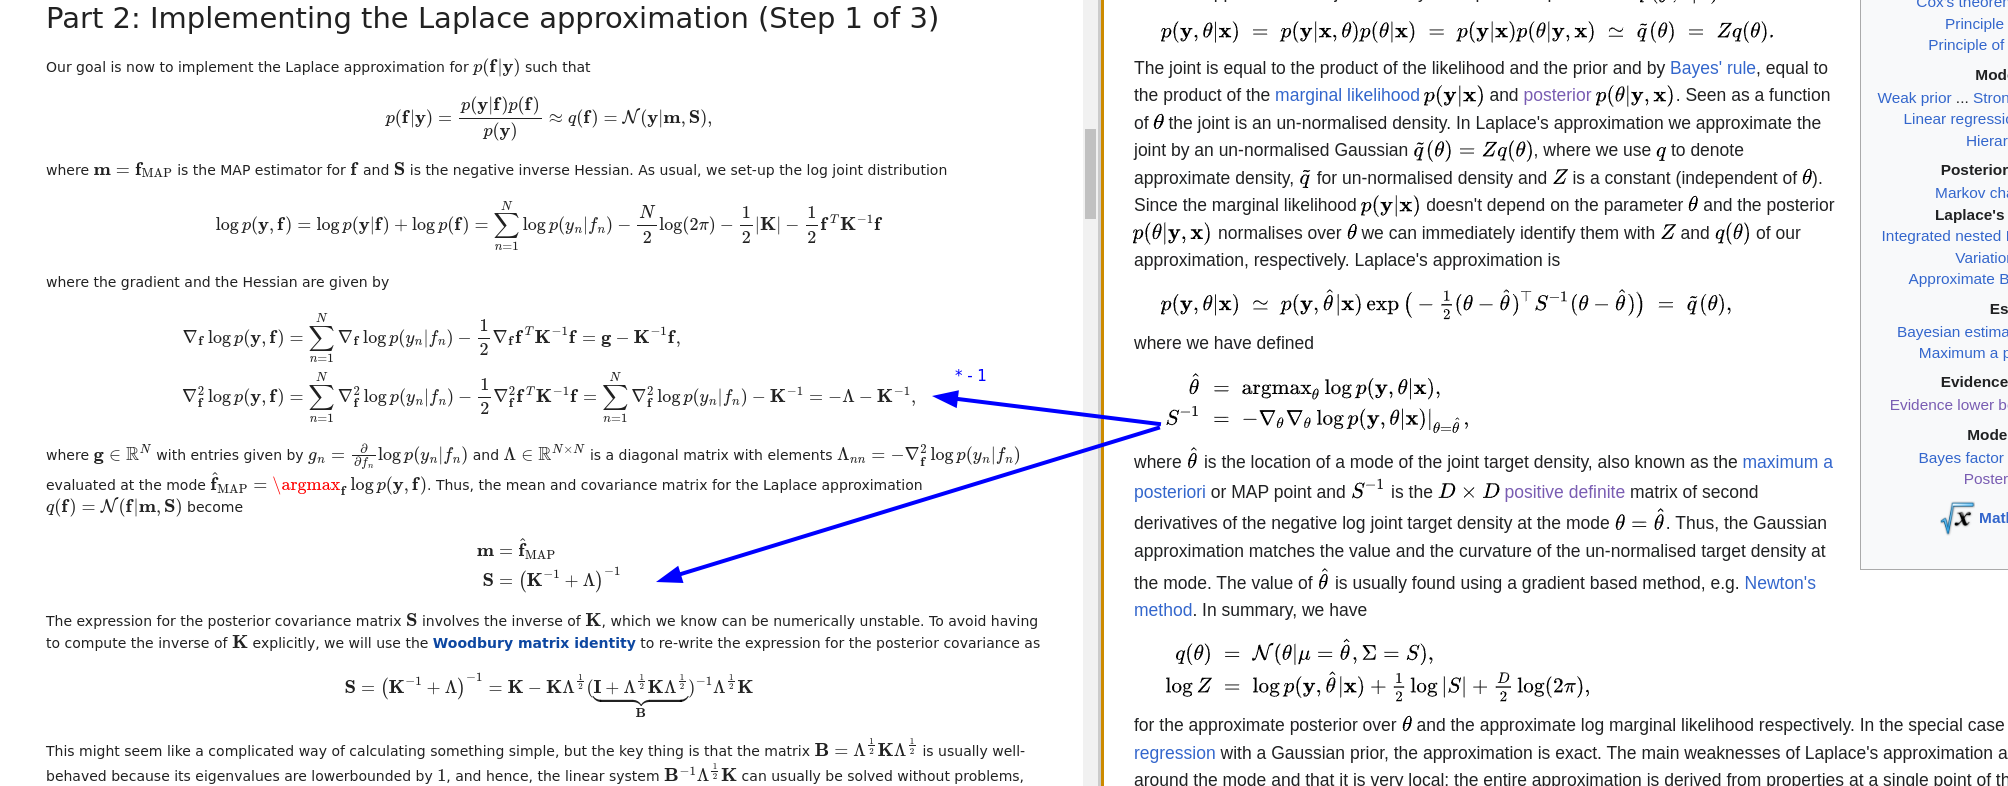

this result holds in general
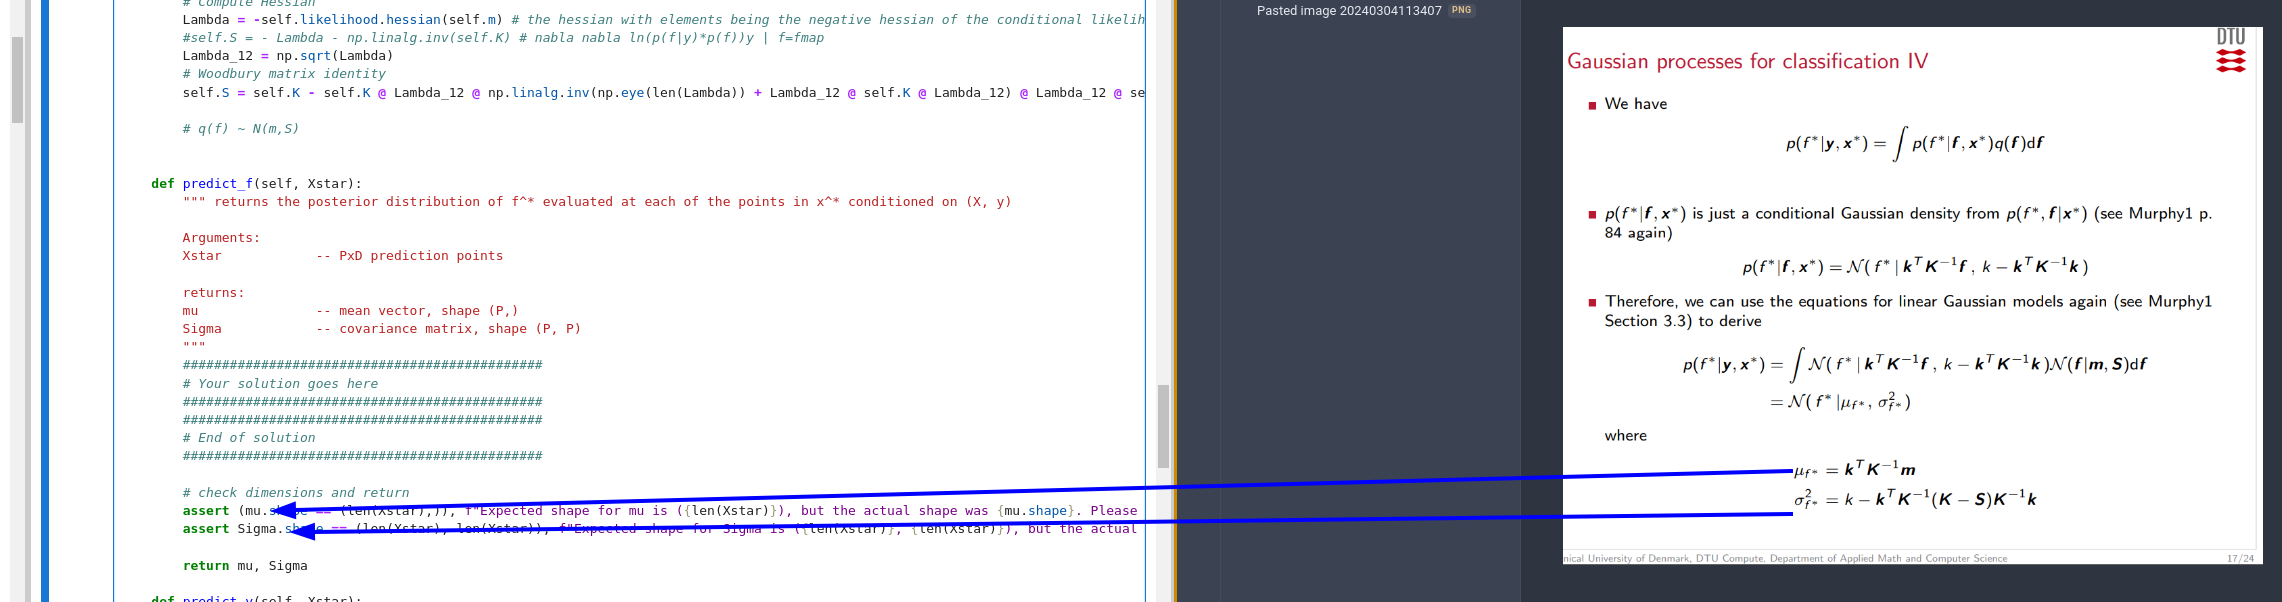

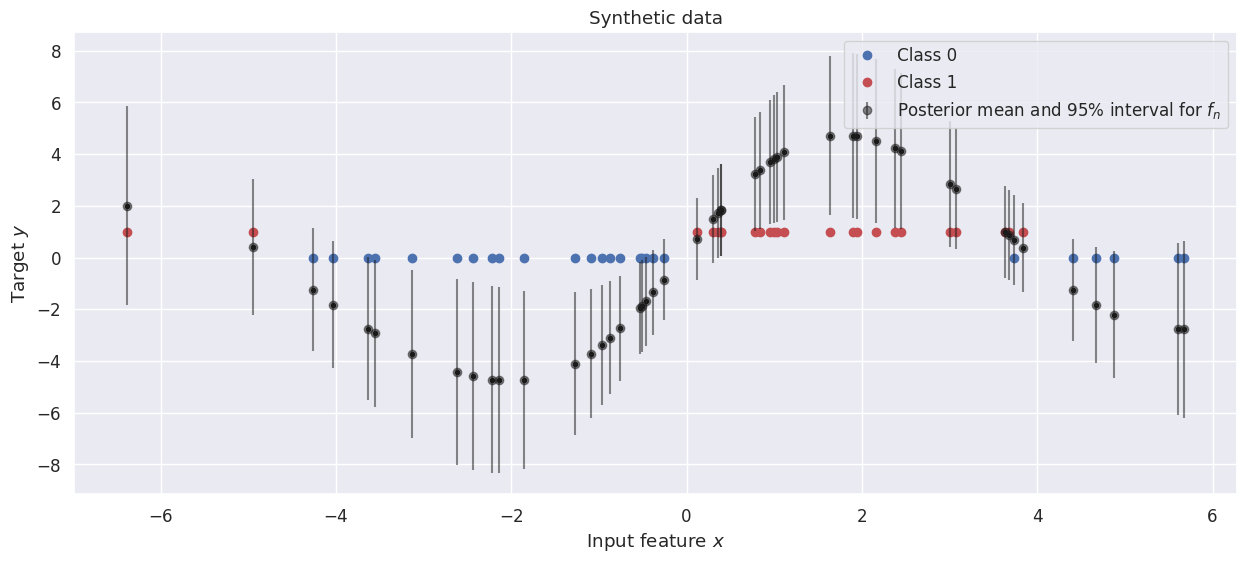

In [66]:
probit = lambda x: norm.cdf(x)

class GaussianProcessClassification(object):

    def __init__(self, X, y, likelihood, kernel, kappa=1., lengthscale=1.,jitter=1e-8):
        """  
        Arguments:
            X                -- NxD input points
            y                -- Nx1 observed values 
            likelihood       -- likelihood instance
            kernel           -- must be instance of the StationaryIsotropicKernel class
            jitter           -- non-negative scaler
            kappa            -- magnitude (positive scalar)
            lengthscale      -- characteristic lengthscale (positive scalar)
        """
        self.X = X
        self.y = y
        self.N = len(X)
        self.likelihood = likelihood(y)
        self.kernel = kernel
        self.jitter = jitter
        self.set_hyperparameters(kappa, lengthscale)

        # precompute kernel, its Cholesky decomposition and prepare Laplace approx
        self.K = self.kernel.contruct_kernel(self.X, self.X, jitter=self.jitter)
        self.L = np.linalg.cholesky(self.K)
        self.construct_laplace_approximation()

    def set_hyperparameters(self, kappa, lengthscale):
        self.kernel.kappa = kappa
        self.kernel.lengthscale = lengthscale
        
    def log_joint_a(self, a):
        """ computes and returns the log joint distribution log p(y, f), where f = K*a """
        f = self.K@a
        # compute log prior contribution
        const = -self.N/2*np.log(2*np.pi)
        logdet = np.sum(np.log(np.diag(self.L)))
        quad_term =  0.5*np.sum(a*f)
        log_prior = const - logdet - quad_term
        # compute log likelihood contribution
        log_lik = self.likelihood.log_lik(f)
        # return sum
        return log_prior + log_lik
    

    def grad_a(self, a):
        """ computes gradient of log joint distribution, i.e. log p(y, a) = log p(y|a) + log p(a), wrt. a """
        f = self.K@a
        # compute gradient contribution from prior and likelihood
        grad_prior = -f
        grad_lik = self.likelihood.grad(f)@self.K
        # sum and return
        return grad_prior + grad_lik
        
    
    def compute_f_MAP(self):
        # optimize to get f_MAP
        result = minimize(lambda a: -self.log_joint_a(a), jac=lambda a: -self.grad_a(a), x0=np.zeros((self.N)))
        
        if not result.success:
            print(result)
            raise ValueError('Optization failed')
        
        self.a = result.x
        f_MAP = self.K @ result.x
        return f_MAP

    def construct_laplace_approximation(self):

        # f_MAP
        self.m = self.compute_f_MAP()

        # Compute Hessian
        Lambda = -self.likelihood.hessian(self.m) # the hessian with elements being the negative hessian of the conditional likelihood
        #self.S = - Lambda - np.linalg.inv(self.K) # nabla nabla ln(p(f|y)*p(f))y | f=fmap
        Lambda_12 = np.sqrt(Lambda)
        # Woodbury matrix identity
        self.S = self.K - self.K @ Lambda_12 @ np.linalg.inv(np.eye(len(Lambda)) + Lambda_12 @ self.K @ Lambda_12) @ Lambda_12 @ self.K

        # q(f) ~ N(m,S)
        

    def predict_f(self, Xstar):
        """ returns the posterior distribution of f^* evaluated at each of the points in x^* conditioned on (X, y)
        
        Arguments:
        Xstar            -- PxD prediction points
        
        returns:
        mu               -- mean vector, shape (P,)
        Sigma            -- covariance matrix, shape (P, P) 
        """
        ##############################################
        # Your solution goes here
        ##############################################
        #k = self.kernel.contruct_kernel(Xstar,self.X, jitter=self.jitter).T
        #k_star = self.kernel.contruct_kernel(Xstar,Xstar, jitter=self.jitter).T
        #K_inv = np.linalg.inv(self.K)
        #print(k.shape,k_star.shape, K_inv.shape, self.S.shape)
        #mu = k.T @ K_inv @ self.m # m is from laplace
        #Sigma = k_star - k.T @ K_inv @ (self.K-self.S) @ K_inv @ k
        
        #the solution above didn't work because of lack of numerical stability
        k = self.kernel.contruct_kernel(Xstar, self.X, jitter=self.jitter)
        Kp = self.kernel.contruct_kernel(Xstar, Xstar, jitter=self.jitter)

        h = np.linalg.solve(self.K, k.T)
        mu = k@np.linalg.solve(self.K, self.m)
        Sigma = Kp - h.T@(self.K-self.S)@h
        
        ##############################################
        # End of solution
        ##############################################

        # check dimensions and return
        assert (mu.shape == (len(Xstar),)), f"Expected shape for mu is ({len(Xstar)}), but the actual shape was {mu.shape}. Please check implementation"
        assert Sigma.shape == (len(Xstar), len(Xstar)), f"Expected shape for Sigma is ({len(Xstar)}, {len(Xstar)}), but the actual shape was {Sigma.shape}. Please check implementation"

        return mu, Sigma
    
    def predict_y(self, Xstar):
        """ returns the posterior distribution of y^* evaluated at each of the points in x^* conditioned on (X, y)
        
        Arguments:
        Xstar            -- PxD prediction points
        
        returns:
        p               -- vector of post. pred. probabilities, shape (P,)
        """
        ##############################################
        # Your solution goes here
        ##############################################
        mu_f_star, Sigma_f_star = self.predict_f(Xstar)
        p = probit(mu_f_star/np.sqrt(8/np.pi + np.diag(Sigma_f_star)))
        ##############################################
        # End of solution
        ##############################################

        # check dimensions and return
        assert (p.shape == (len(Xstar),)), f"Expected shape for p is ({len(Xstar)}), but the actual shape was {p.shape}. Please check implementation"
        return p
    
    def posterior_samples(self, Xstar, num_samples):
        """
            generate samples from the posterior p(f^*|y, x^*) for each of the inputs in Xstar

            Arguments:
                Xstar            -- PxD prediction points
        
            returns:
                f_samples        -- numpy array of (P, num_samples) containing num_samples for each of the P inputs in Xstar
        """
        mu, Sigma = self.predict_f(Xstar)
        f_samples = generate_samples(mu.ravel(), Sigma, num_samples)

        assert (f_samples.shape == (len(Xstar), num_samples)), f"The shape of the posterior mu seems wrong. Expected ({len(Xstar)}, {num_samples}), but actual shape was {f_samples.shape}. Please check implementation"
        return f_samples

# prep kernel, likelihood and Gaussian process
kernel = StationaryIsotropicKernel(squared_exponential)
likelihood = BernoulliLikelihood
gpc = GaussianProcessClassification(X, y, likelihood, kernel, kappa=3., lengthscale=1.5)

# plot data and visualize posterior
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
plot_data(ax, X, y)
ax.plot(X, gpc.m, 'k.')
ax.errorbar(X, gpc.m, yerr=1.96*np.sqrt(np.diag(gpc.S)), fmt='ko', label='Posterior mean and 95% interval for $f_n$', alpha=0.5)
ax.legend();

If your implementation is correct, the code above visualizes the Laplace approximation superimposed on the data.

**Task 2.4**: Explain what you see in the plot above. That is, what does the entries of the posterior mean vector $\mathbf{m}$ represent? What about the entries in the posterior covariance matric $\mathbf{S}$? [**Discussion question**]

*Hints: What are the dimensions of the mean $\mathbf{m}$ and the covariance $\mathbf{S}$ of the Laplace approximation?*

the laplace entry approximates $p(y|f)$, so I suppose the interval is an approximation of y|f, we generally see a higher value for class 1 than for class 0, which indicates, we have learnt an okay classifier with a thresholding function of sign(f)?.

m, S are the approximate mean and covariance of y|f, thus it shows us how the features are distributed given a normal assumption.

## Part 3:  Implementing the posterior distribution of $p(f^*|\mathbf{y}, \mathbf{x}^*)$ (step 2 of 3)

We are now ready for step 2, which is to compute the posterior distribution of the latent function evaluated at a new point $\mathbf{x}^*$, i.e to compute $p(f^*|\mathbf{y}, \mathbf{x}^*)$ where $f^* = f(\mathbf{x}^*)$. Informally, we want to be able to "fill the gaps" in the plot above.

Using the posterior approximation $q(\mathbf{f}) = \mathcal{N}(\mathbf{f}|\mathbf{m}, \mathbf{S})$, we can compute the approximate posterior for $f^* = f(\mathbf{x}^*)$ when evaluated at any $\mathbf{x}^*$ as follows:

$$\begin{align*}
p(f^*|\mathbf{y}, \mathbf{x}^*) &= \int p(f^*|\mathbf{f}, \mathbf{x}^*) p(\mathbf{f}|\mathbf{y}) \text{d} \mathbf{f}\approx  \int p(f^*|\mathbf{f}) q(\mathbf{f}) \text{d} \mathbf{f}.
\end{align*}$$

Since $p(\mathbf{f}, f^*)$ is a multivariate Gaussian, the conditional distribution $p(f^*|\mathbf{f})$ will also be a Gaussian, where the mean and covariance is given by the general equations on p. 84 in Murphy1 (you will derive them below). 





Moreover, since $q(\mathbf{f})$ is also Gaussian, we can solve the integral above by recognizing that this integral is equivalent to a marginalization in a linear Gaussian system (see Section 3.3 in Murphy1). The results becomes

$$\begin{align*}
p(f^*|\mathbf{y}, \mathbf{x}^*) \approx  \mathcal{N}(f^*|\mu_{f^*|\mathbf{y}}, \sigma^2_{f^*|\mathbf{y}}),
\end{align*}$$

where 

$$\begin{align*}
\mu_{f^*|\mathbf{y}} &=  \mathbf{k}^T \mathbf{K}^{-1} \mathbf{m},\\
\sigma^2_{f^*|\mathbf{y}} &= c - \mathbf{k}^T \mathbf{K}^{-1} (\mathbf{K} - \mathbf{S}) \mathbf{K}^{-1} \mathbf{k}
\end{align*}$$

where $c = k(\mathbf{x}_*, \mathbf{x}_*)$ is the prior variance of $f^*$, $\mathbf{k} \in \mathbb{R}^N$ is a vector with entries given by $\mathbf{k}_n = k(\mathbf{x}_*, \mathbf{x}_n)$, and $\mathbf{K} \in \mathbb{R}^{N \times N}$ is prior covariance of $\mathbf{f}$. If you want to compute the joint distribution the predictions for $P$ input points $\mathbf{x}^*$ at once, then $\mathbf{k}$ becomes a $P \times N$-matrix and $c$ becomes a $P \times P$-matrix.







Before implementing this part, we will elaborate a bit on some of the details above. 

**Task 3.1**: Write the expression for the prior mean and the prior covariance matrix for the joint Gaussian distribution $p( f^*, \mathbf{f})$ in terms of the kernel quantitites $\mathbf{K}$, $\mathbf{k}$ and $k$.

*Hints: What is the prior mean of $\mathbf{f}$ and $f^*$? What is the prior variance of $\mathbf{f}$ and $f^*$? What is the prior covariance between $\mathbf{f}$ and $f^*$?*




So, we have p(f) = N(0,K).
The mean will still be 0, but we evaluate the covairance between xstar and x.
So

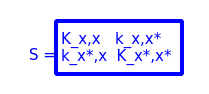







**Note**: The next task will make use of your solution from the previous task, so you might want to verify it before continuing.



**Task 3.2**: Write the expression for the mean and covariance of the conditional distribution $p(f^*|\mathbf{f}, \mathbf{x}^*)$ using the solution to the previous task.

*Hints: Use the equations (3.26) and (3.28)  on p. 84 in Murphy1.*



It seems like they just want us to disregard the x* and calculate f*|f, which is kind of weird.

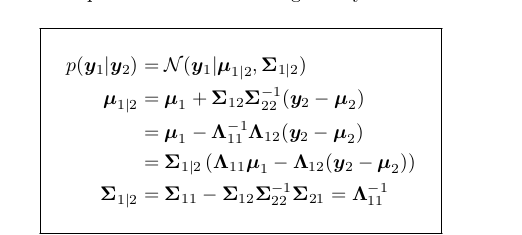





using the above connection, we get
a normal distribution with a mean

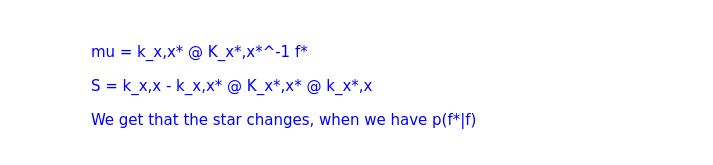


We are now ready to implemenet the distribution $p(f^*|\mathbf{y}, \mathbf{x}^*)$.

**Task 3.3**: Go back up the class `GaussianProcessClassification` and complete the implementation of the function `predict_f` using the equations above.

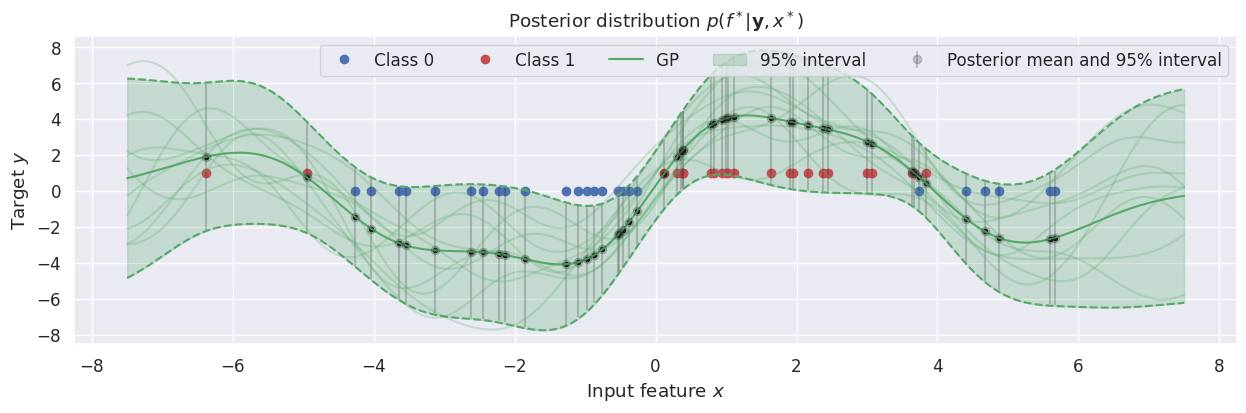

In [73]:
# prep model
kernel = StationaryIsotropicKernel(squared_exponential)
likelihood = BernoulliLikelihood
gpc = GaussianProcessClassification(X, y, likelihood, kernel, kappa=3, lengthscale=1)

# predict
mu, Sigma = gpc.predict_f(Xstar)

# plot
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
plot_data(ax, X, y)
ax.plot(X, gpc.m, 'k.')
ax.errorbar(X, gpc.m, yerr=1.96*np.sqrt(np.diag(gpc.S)), fmt='ko', label='Posterior mean and 95% interval', alpha=0.2)
plot_with_uncertainty(ax, Xstar, mu, Sigma, color='g', title='Posterior distribution $p(f^*|\mathbf{y}, x^*)$', num_samples=10)
ax.legend(ncol=5);


**Task 3.4**: Play around with the kernel and hyperparameter settings and describe how they affect the resulting plot [**Discussion question**]

Changing kappe moves the uncertainty regions up or down.
And changning the length scale changes the flexibility of the model, which makes sense, because it changes the frequency of the model.


## Part 4:  Compute the posterior predictive distribution of the label $y^*$ for the input point $\mathbf{x}^*$, i.e. to compute $p(y^*|\mathbf{y}, \mathbf{x}^*)$. (Step 3 of 3)


Finally, after having obtained the distribution $p(f^*|\mathbf{y})$, we can use this distribution to compute the posterior predictive distribution $p(y^*|\mathbf{y}, \mathbf{x}^*)$

$$
\begin{align*}
p(y^* = 1|\mathbf{y}, \mathbf{x}^*) \approx \int \sigma(f^*) p(f^*|\mathbf{y}) \text{d} f^*.
\end{align*}
$$

We will use the **probit approximation**, which approximates the sigmoid as follows: $\sigma(f^*) \approx \Phi(f^* \sqrt{\frac{\pi}{8}})$, where $\Phi$ is the cumulative distribution function of the standard normal distribution. The benefit is that the expectation value of the approximation can be computed analytically as follows:
$$
\begin{align*}
p(y^* = 1|\mathbf{y}, \mathbf{x}^*) \approx \int \sigma(f^*) p(f^*|\mathbf{y}, \mathbf{x}^*) \text{d} f^* \approx \int \phi\left(f^* \sqrt{\frac{\pi}{8}}\right) p(f^*|\mathbf{y}, \mathbf{x}^*) \text{d} f^* = \Phi\left(\frac{\mu_{f^*}}{\sqrt{\frac{8}{\pi} + \sigma^2_{f^*}}}\right) \tag{3}
\end{align*}
$$

**Task 4.1**: Go back up the class `GaussianProcessClassification` and complete the implementation of the function `predict_y` using the probit approximation.


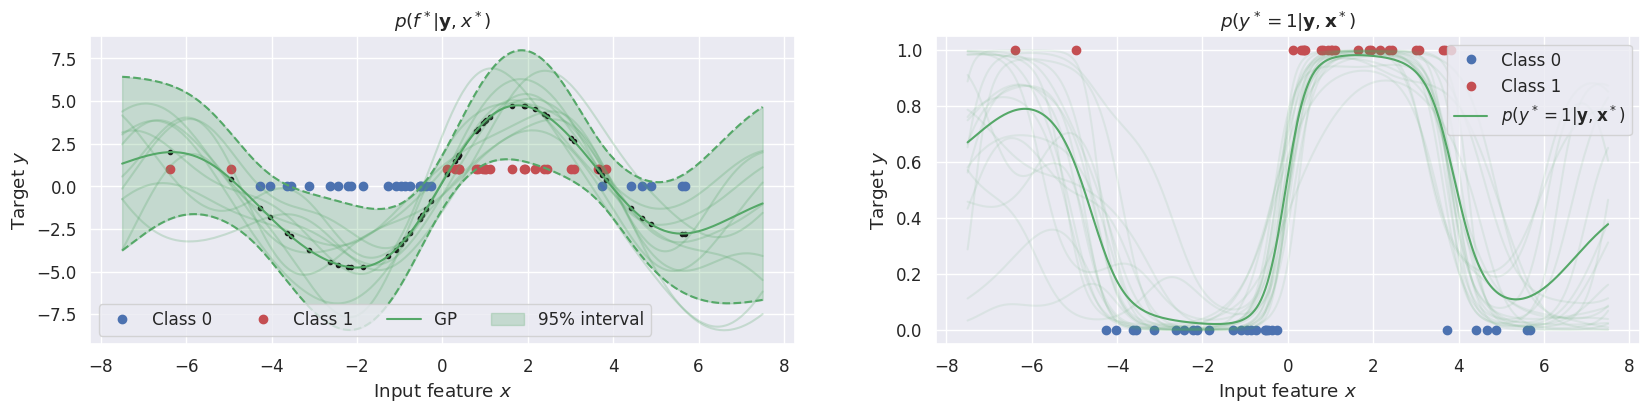

In [55]:
# prep model
kernel = StationaryIsotropicKernel(squared_exponential)
likelihood = BernoulliLikelihood
gpc = GaussianProcessClassification(X, y, likelihood, kernel, kappa=3., lengthscale=1.5)

# predict 
mu, Sigma = gpc.predict_f(Xstar)
p = gpc.predict_y(Xstar)

# compute prediction distribution p(f^*|y, x^*) and p(y^*|y, x^*)
f_samples = generate_samples(mu[:, None], Sigma, 20).T
p_samples = sigmoid(f_samples)

# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
plot_data(ax[0], X, y)
plot_data(ax[1], X, y)

ax[0].plot(X, gpc.m, 'k.')
plot_with_uncertainty(ax[0], Xstar, mu, Sigma, color='g', title='$p(f^*|\mathbf{y}, x^*)$', num_samples=10)
ax[0].legend(ncol=5)

ax[1].plot(Xstar, p, 'g-', label='$p(y^*=1|\mathbf{y}, \mathbf{x}^*)$')
ax[1].plot(Xstar.ravel(), p_samples.T, 'g-', alpha=0.1)
ax[1].legend()
ax[1].set(title='$p(y^*=1|\mathbf{y}, \mathbf{x}^*)$');

If the code has been implemented correct, the code above produces plot of the posterior distribution $p(f^*|\mathbf{y}, \mathbf{x}^*)$ and the posterior predictive $p(y^*=1|\mathbf{y}, \mathbf{x}^*)$

**Task 4.2**: Inspect the plots above. Comment on the behavior of the posterior predictive distribution. Which regions of the input space is dominated by aleatoric uncertainty and which are dominated by epistemic uncertainty? [**Discussion questions**]

the ones with less data points are from epistemic, which we see at the tails.
The inherent/aleatoric uncertainty is in the areas with data point from the representations, being quite close to each other really.

For comparison, we will set-up a simple neural network model as a baseline. We will use a two layer network with 20 neuron in each hidden layer. We will impose an i.i.d. Gaussian prior on all the weights, i.e. $p(w_i) \sim \mathcal{N}(0, \alpha^{-1})$ and use a MAP-estimator for the weights. We will not dive into the details of this model, but simply use it as a baseline. The class `NeuralNetworkMAP` implements estimator a MAP-estimator for the neural network model and the code can be found in the module called `exercise6.py` if you are curious.

The cell below shows the predictive distribution for the network obtained using the plugin approximation compared with the Guassian process:


In [56]:
# fit the NN model with 1 input dimension, 2 hidden layers of 20 neurons each, and 1 output
nn = NeuralNetworkMAP(X, y, [1, 20, 20, 1], alpha=1., likelihood=BernoulliLikelihood)

# !! NN doesn't work, because of vectorize implementation, 
# !! but like honestly duck the autograd library to some extent.

# predict using neural network
y_nn = nn.predict(Xstar)
p_nn = sigmoid(y_nn)

# plot
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
plot_data(ax, X, y)
ax.plot(Xstar, p, 'g-', label='$p(y^*=1|\mathbf{y}, \mathbf{x}^*)$')
ax.plot(Xstar.ravel(), p_samples.T, 'g-', alpha=0.1)
ax.set(title='$p(y^*=1|\mathbf{y}, \mathbf{x}^*)$ (GP)');
ax.plot(Xstar, p_nn, label='$p(y^*=1|\mathbf{y}, \mathbf{x}^*)$ (NN-MAP)')
ax.legend();



TypeError: loop of ufunc does not support argument 0 of type ArrayBox which has no callable log method

**Task 4.3**: Compare the predictive distribution for the neural network and the Gaussian process. How do they differ (qualitatively) within the support of the data?
 Outside the support of the data? [**Discussion question**]

 *Hint*: Go to the top of the notebook and increase the prediction range for ´Xstar´, e.g. from $\left[-7.5, 7.5\right]$ to $\left[-15, 15\right]$*


They differ at the tails, where we lack data points, which makes sense as the NN is MAP.


**Task 4.4**: What happens if you increase $\alpha$ from $1$ to e.g. $10$ or decrease it to $0.01$? Can you explain the result? **[Discussion question]**

*Hint: Recall the relationship between Gaussian priors and regularization when using MAP estimates*

Alpha is the neural networks length scale, so the frequency of it, which makes the network less flexible the higher the alpha. At 10 it is a line.

# Part 5:  Gaussian process classification for 2D data set

We will now use the MNIST data from week 4 to further study the properties of Gaussian process models.

The function in the cell below loads the MNIST data and projects the data to a 2-dimensional space using PCA as we did in week 3.

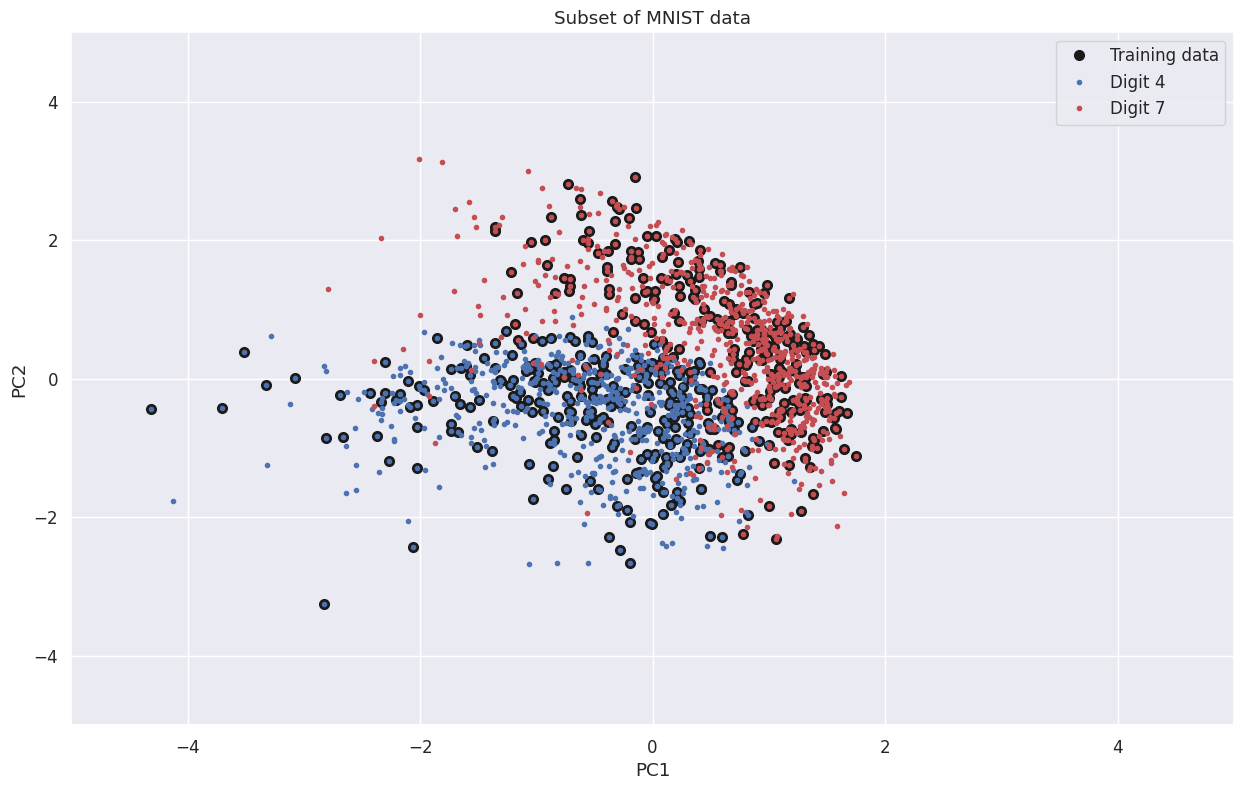

In [58]:
digits = [4, 7]
Xtrain, Xtest, ytrain, ytest = load_MNIST_subset('./mnist_subset.npz', digits=digits, subset=500)

# make sure dimensions are [N x 1]
ytrain = ytrain[:, None]
ytest = ytest[:, None]

X = np.row_stack((Xtrain, Xtest))
y = np.row_stack((ytrain, ytest))

# plot
def plot_data(ax, title="", xlim=(-5, 5), ylim=(-5, 5)):
    ax.plot(Xtrain[:, 0], Xtrain[:, 1], 'ko', markersize=7, label='Training data')
    ax.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], 'b.', label='Digit %d' % digits[0])
    ax.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], 'r.', label='Digit %d' % digits[1])
    ax.set_xlim((-5,5 ))
    ax.set_ylim((-5,5 ))
    ax.set(title=title, xlim=xlim, ylim=ylim, xlabel='PC1', ylabel='PC2')
    ax.legend()

fig, ax = plt.subplots(1,1, figsize=(15,9))
plot_data(ax, title='Subset of MNIST data')

Let's fit the Gaussian process

In [59]:
# Gaussian process
kernel = StationaryIsotropicKernel(squared_exponential)
gpc = GaussianProcessClassification(Xtrain, ytrain, BernoulliLikelihood, kernel, kappa=1, lengthscale=1)

... and plot the result

Training error:	0.08 (0.01)
Test error:	0.08 (0.01)


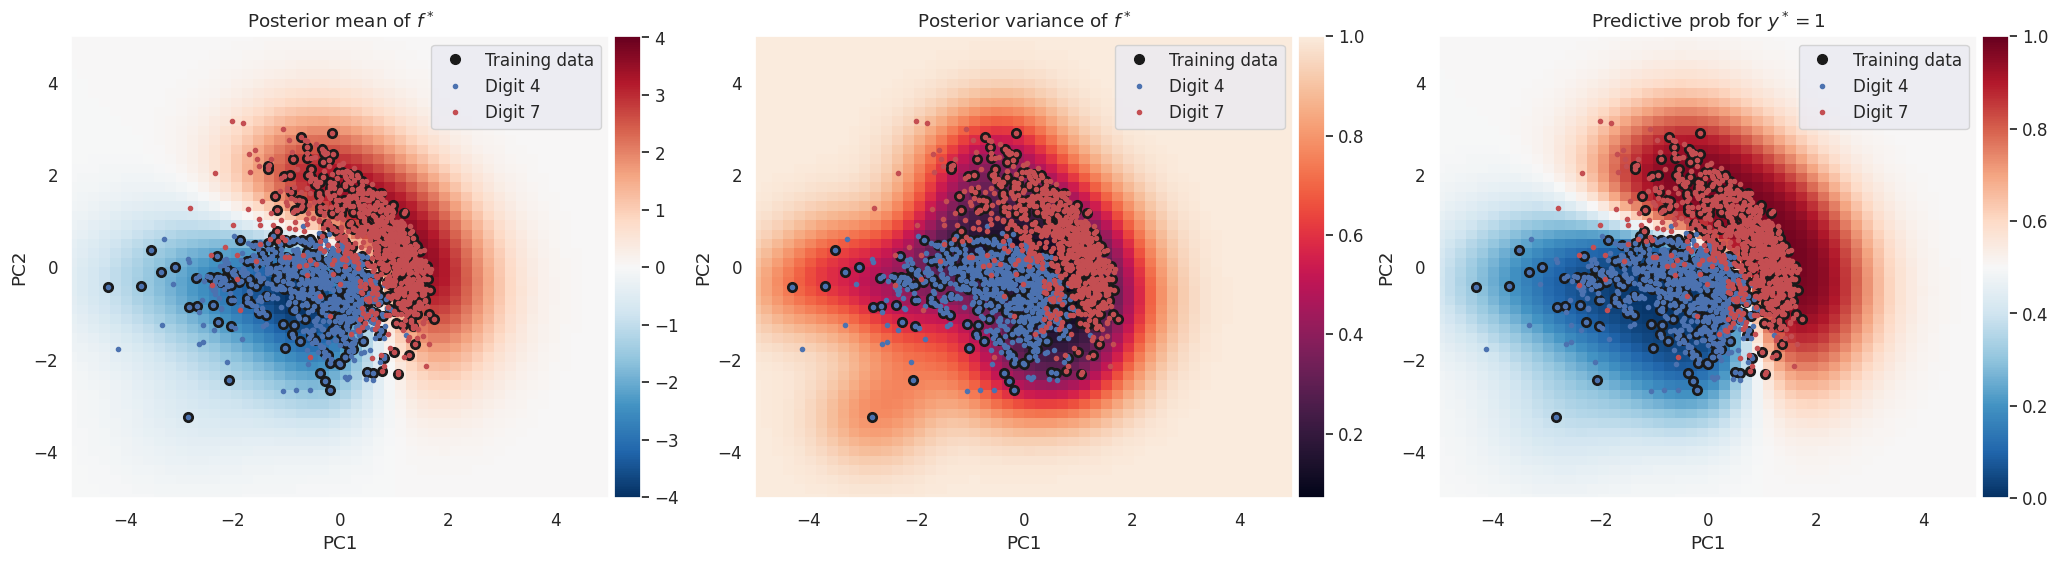

In [60]:
# predict
p_train = gpc.predict_y(Xtrain)
p_test = gpc.predict_y(Xtest)

# make predictions
ytrain_hat = 1.0*(p_train > 0.5)
ytest_hat = 1.0*(p_test > 0.5)

# print results: mean and standard error of the mean
print('Training error:\t%3.2f (%3.2f)' % compute_err(ytrain_hat.ravel(), ytrain.ravel()))
print('Test error:\t%3.2f (%3.2f)' % compute_err(ytest_hat.ravel(), ytest.ravel()))

# prepare for plotting
x_grid, posterior_y_gpc_eval_mu = eval_density_grid(lambda x: gpc.predict_f(x)[0], P=50, )
x_grid, posterior_y_gpc_eval_var = eval_density_grid(lambda x: np.diag(gpc.predict_f(x)[1]), P=50)
x_grid, posterior1_gpc_eval = eval_density_grid(gpc.predict_y, P=50, a=-5, b=5)

# prepare plot
fig, ax = plt.subplots(1, 3, figsize=(25, 6))

# plot posterior mean
im = ax[0].pcolormesh(x_grid, x_grid, posterior_y_gpc_eval_mu, cmap=plt.cm.RdBu_r, norm=colors.CenteredNorm(), shading='auto')
plot_data(ax[0], title="Posterior mean of $f^*$")
add_colorbar(im, fig, ax[0])

# plot posterior var
im = ax[1].pcolormesh(x_grid, x_grid, posterior_y_gpc_eval_var, shading='auto')
plot_data(ax[1], title="Posterior variance of $f^*$")
add_colorbar(im, fig, ax[1])

# plot posterior predictive
im = ax[2].pcolormesh(x_grid, x_grid, posterior1_gpc_eval, cmap=plt.cm.RdBu_r, shading='auto', clim=(0, 1))
plot_data(ax[2], title="Predictive prob for $y^* = 1$")
add_colorbar(im, fig, ax[2])

**Task 5.1**: Explain what you see in the 3 panels - explain the difference between the two distributions $p(f^*|\mathbf{y})$ and $p(y^*|\mathbf{y})$ [**Discussion question**]

The difference between the two distributions is before and after we apply our decision rule.
In the plots we see the variance of f star around the datapoints isn't that great, but approaches a univariate one after we leave, which makes sense as it is just random there. In the last plot we see the model is good at predicting which one is a 7 and a 4 as the regions are cold and hot where they should be.

**Task 5.2**: What does the values of mean $\mathbf{m}$ in the Laplace approximation $q(\mathbf{f}) = \mathcal{N}(\mathbf{f}|\mathbf{m}, \mathbf{S})$ represent and how does it relate to the figures? [**Discussion question**]

it represents the f|y the approximate mean value of f given some class y
it relates to the figures in sense that we see different means given the data points in question.

**Task 5.3**: Comment on the uncertainties within the support of the data and outside the data. Compare with the equivalent plots for the NN below [**Discussion question**]

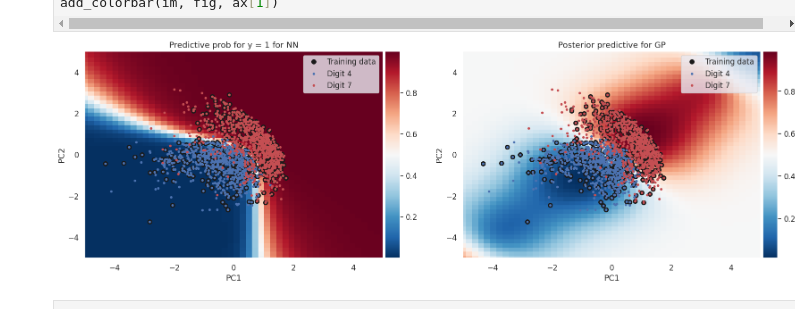

we see the GP makes a cloud behind the data, but is uncertain when we leave the most dense region. The neural network is really only unsure on the border between the two data points, so where it has put its seperation layer, this makes sense in terms of if a sigmoid or tanh is used which maps everything to essentially 0 or 1.

In [61]:
nn = NeuralNetworkMAP(Xtrain, ytrain, [2, 20, 20, 1], alpha=1., likelihood=BernoulliLikelihood)

x_grid, posterior1_nn_eval = eval_density_grid(lambda x: sigmoid(nn.predict(x)), P=50, a=-5, b=5)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
im = ax[0].pcolormesh(x_grid, x_grid, posterior1_nn_eval, cmap=plt.cm.RdBu_r, shading='auto')
plot_data(ax[0], title='Predictive prob for y = 1 for NN')
add_colorbar(im, fig, ax[0])

plot_data(ax[1], title='Posterior predictive for GP')
im = ax[1].pcolormesh(x_grid, x_grid, posterior1_gpc_eval, cmap=plt.cm.RdBu_r, shading='auto')
add_colorbar(im, fig, ax[1])

TypeError: loop of ufunc does not support argument 0 of type ArrayBox which has no callable log method